# Bayesian Statistics Tutorial

We will be using the pymc3 package to do some Bayesian analyses. You will not be asked to do a lot of coding yourself, but to follow the code already in this tutorial, understand the output, answer some questions about the results and tweak it yourself afterwards.

In [48]:
# Dependencies
%matplotlib inline
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pandas as pd

plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.6


## Generate an AR(1) Process

Let's generate some data, keeping the data generator parameters the same as in the AR(1) exercise from earlier on today. We can do a simple plot afterwards just to see what it looks like.

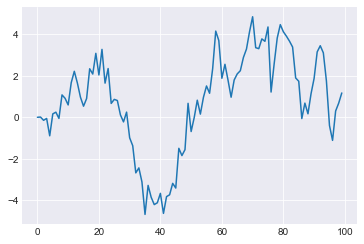

In [2]:
np.random.seed(seed=1848)

T = 100
y = np.zeros((T,))
rho = 0.95

for i in range(1,T):
    y[i] = rho * y[i-1] + np.random.normal()

plt.plot(y);

## Run Bayesian AR(1) Model

To run any Bayesian model, we need to have our ingredients:
- **The model**: in this case an AR(1) model
- **The data**: already generated
- **The priors**: defined below

In addition to these, we will also need to specify some computation-specific parameters:
- **Number of chains**: How many Markov chains do we want to compute? Below, this is set to 2
- **Sample per chain**: How many samples should be taken from each Markov chain? Below, this is set to 2000
- **Tune**: How much of the initial marginal posterior distribution should be sampled as an initial burn-in? This is set to 2000
- **Sampling Method**: Default for pymc3 is NUTS (No U Turn Sampling). Below we use Metropolis-Hastings

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [beta]
Sampling 2 chains: 100%|██████████████| 8000/8000 [00:06<00:00, 1290.53draws/s]
The number of effective samples is smaller than 25% for some parameters.


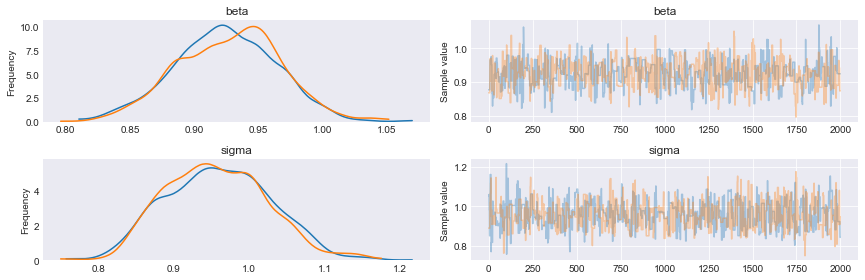

In [38]:
# Number of chains
chains = 2
# Number of posterior samples to get from the posterior distribution, per parameter
sample = 2000

# Run the model
with pm.Model() as ar1:
    # "beta" is our estimated rho
    beta = pm.Normal('beta', mu = 0, sd = 1e2)
    # The prior for the noise in the data
    sd_prior = pm.Gamma('sigma', alpha = 1e-3, beta = 1e-3) 
    # We specify the data as following an AR(1) model
    data = pm.AR('y', beta, sd = sd_prior, observed = y)
    # Run the Markov chains
    trace = pm.sample(sample, cores = chains, tune = 2000, step = pm.Metropolis())

pm.traceplot(trace);

We can get detailed histograms of the parameters' marginal posterior densities

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000011ED4BE0>,
      dtype=object)

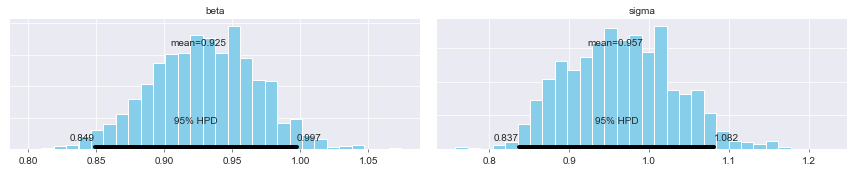

In [39]:
pm.plot_posterior(trace)

Look at how the posterior density compares to the prior

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000011A2AC18>,
      dtype=object)

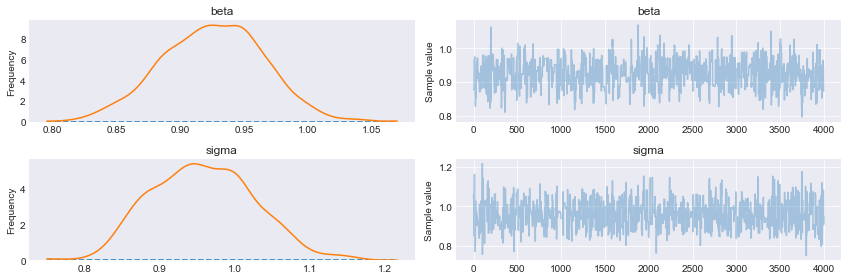

In [40]:
pm.traceplot(trace, combined = True, priors = [pm.Normal.dist(mu = 0, sd = 1e2), pm.Gamma.dist(alpha = 1e-3, beta = 1e-3)])

Some questions about the last outputs:
1. Are there any obvious biases in the estimated rho (i.e. beta) values? Remember that rho = 0.95
2. How does it differ from the plot of the AR(1) rho estimates we did before in the day?
3. If there is a difference, where is this coming from?

One potential issue with Markov chains are that the draws can be correlated to each other. Let's do an autocorrelation plot of the estimated parameters to see if this is an issue. 

Are there any obvious autocorrelation issues?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000013996D68>,
      dtype=object)

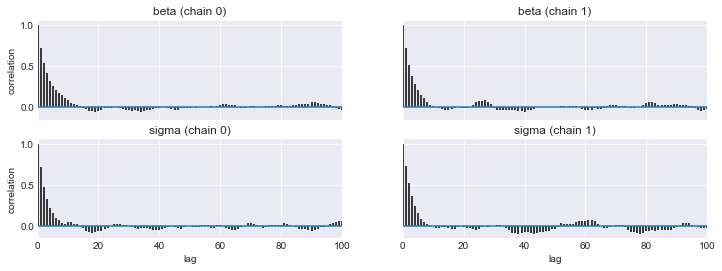

In [41]:
pm.autocorrplot(trace)

There are indeed some auto-correlation issues within the chain. We can thin the chains 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000133BDA20>,
      dtype=object)

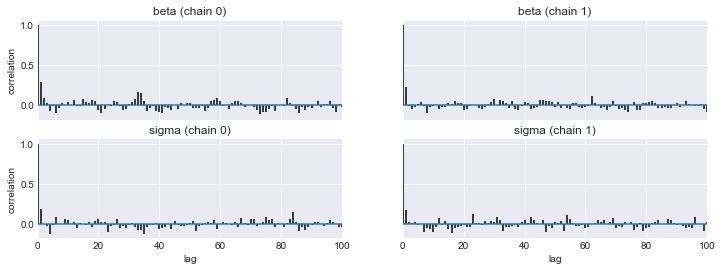

In [42]:
pm.autocorrplot(trace[::5])

Now let's tweak our model to try and improve some of the issues we had:

- Bias in the Bayesian estimator of beta
  - According to [this](https://arxiv.org/ftp/arxiv/papers/1611/1611.08747.pdf) paper, giving the estimator a truncated normal distribution as a prior reduces the bias
- Autocorrelation
  - The No U Turn Sampler (NUTS) in pymc3 theoretically avoids autocorrelation issues. How it does this is, admittedly, a bit complicated. You can find a discussion, with some links, [here](https://stats.stackexchange.com/questions/311813/can-somebody-explain-to-me-nuts-in-english)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta]
Sampling 2 chains: 100%|███████████████| 8000/8000 [00:15<00:00, 509.29draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


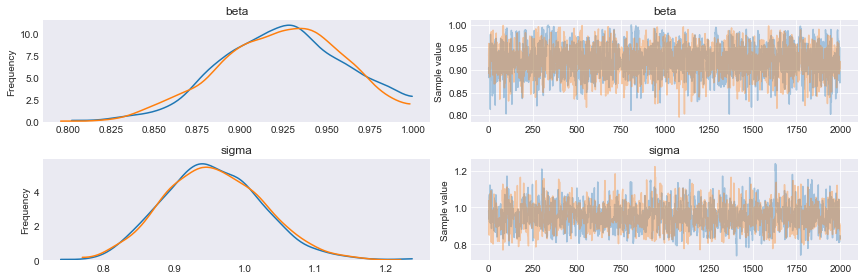

In [43]:
with pm.Model() as ar1:
    # truncate the prior of beta between -1 and 1
    BoundedNormal = pm.Bound(pm.Normal, upper = 1.0, lower = -1.0)
    beta = BoundedNormal('beta', mu = 0, sd = 1e2)
    sd_prior = pm.Gamma('sigma', alpha = 1e-3, beta = 1e-3) 
    data = pm.AR('y', beta, sd = sd_prior, observed = y)
    trace = pm.sample(sample, cores = chains, tune = 2000)

pm.traceplot(trace);

Have we solved some of the issues? The chains seem more converged than before, but there is still a bias. Let's see if we still have an autocorrelation issue

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000014E37748>,
      dtype=object)

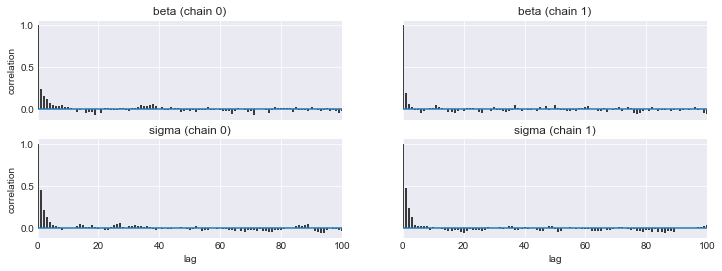

In [45]:
pm.autocorrplot(trace)

At least we have no more autocorrelation in the posterior draws! 

Below, we can see a summary table of the marginal posterior draws.

What do the following columns indicate? Write as if you are explaining it to your business counter part in a project/manager/grandmother/neighbor. Don't worry, technical explanations are provided in the URLs in the parentheses!
- mean (tip: https://docs.pymc.io/api/stats.html)
- sd (tip: https://docs.pymc.io/api/stats.html)
- mc_error (tip: https://docs.pymc.io/api/stats.html)
- hpd_2.5 (tip: https://docs.pymc.io/api/stats.html)
- hpd_97.5 (tip: https://docs.pymc.io/api/stats.html)
- n_eff (tip: thttps://docs.pymc.io/api/diagnostics.html)
- Rhat (tip: https://docs.pymc.io/api/diagnostics.html)

Bonus Questions: 
- Based on your estimation, would you conclude that the data has a unit root (beta = 1)? Motivate your answer!
- Based on this summary, would you change anything about this particular run of the AR(1) model? If so, why? If not, why not?

In [46]:
pm.summary(trace).round(4)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta,0.9235,0.0356,0.0008,0.8603,0.9949,1941.5467,1.0001
sigma,0.9549,0.0697,0.0018,0.8241,1.0938,1380.5777,1.0000


Now let's play around with the prior of beta
1. Change prior of beta to a uniform distribution (-5, 5) and re-run everything. Did this change anything?
2. Make the prior much more informative in the correct range (-1, 1) and then the incorrect range (2, 3). What happens?

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta]
Sampling 2 chains: 100%|███████████████| 8000/8000 [00:15<00:00, 514.80draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5953270895836142, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta,0.9244,0.0364,0.0010,0.8639,0.9999,1073.9921,1.0017
sigma,0.9567,0.0705,0.0017,0.8256,1.0882,1626.7805,1.0008


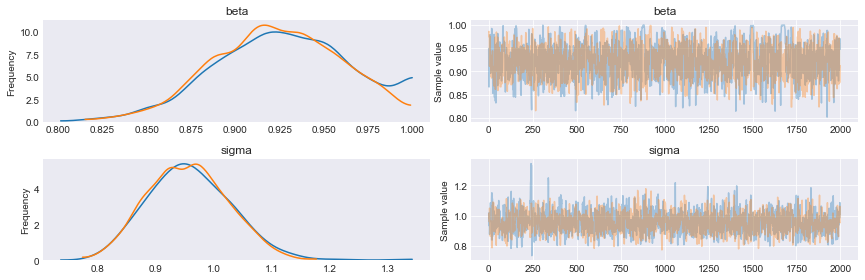

In [50]:
chains = 2
sample = 2000

with pm.Model() as ar1:
    beta = pm.Uniform('beta', lower = -1, upper = 1)
    sd_prior = pm.Gamma('sigma', alpha = 1e-3, beta = 1e-3) 
    data = pm.AR('y', beta, sd = sd_prior, observed = y)
    trace = pm.sample(sample, cores = chains, tune = 2000)

pm.traceplot(trace);
pm.summary(trace).round(4)

# Using Real Data

Now it's time for you to try out what you learned above by yourself with real data! Below you can find the code to load ING's daily stock price data (closing). It is sub-setted to between the 1st of February 2018 - 1st of February 2019. This period marks the first year of Mehmet's (one of the workshop presenters) employment at ING. He is happy about it. However, it seems ING's stock price is not so happy about it.




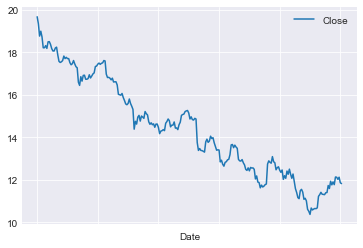

In [49]:
# Get ING stock prices data (Yahoo Finance)
data = pd.read_csv('ING.csv')
# Make closing daily price the variable of interest
data = data[['Date','Close']]
# Set Date as index
data = data.set_index('Date')
# Subset to Feb 2018 - Feb 2019
data = data.loc['2018-02-01':'2019-02-01']
data.plot()

## Questions

1. Run an AR(1) model on this dataset. The code from above is more than enough to help you. Make sure you are able to:
  - Motivate your priors
  - Explain the result
  - Claim whether the chains have converged or not
  - Claim whether there is any auto-correlation in the chains or not

2. Change your model from question 1 by:
  - Setting more/less informed priors
  - Changing the distribution of the priors
  - Trying out a different sampler for the chains
 
3. Is the series stationary? 
  - Run tests (hint: remember the ARIMA exercises from earlier on today)

4. Based on your answer to question 3, is the AR(1) model the most appropriate to apply to this data? Motivate your answer!
